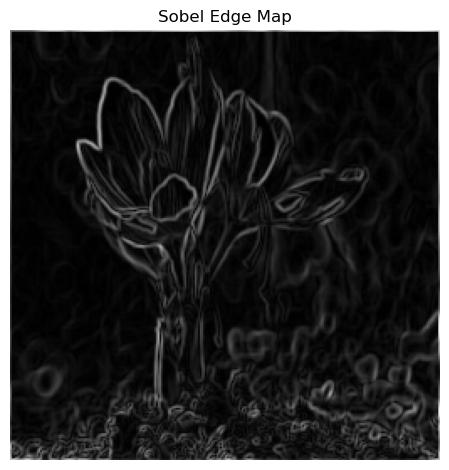

Edge map saved to: sobel_output/sobel_edge_map.png


In [1]:
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as T
import os

def sobel_edge(img: torch.Tensor, normalize: bool = True, return_grads: bool = False):
    """
    Apply Sobel edge detection to a 4D tensor image (B, C, H, W).

    Args:
        img (torch.Tensor): Input tensor with shape (B, C, H, W), values in [0, 1].
        normalize (bool): If True, normalize edge magnitude to [0, 1].
        return_grads (bool): If True, also return grad_x and grad_y.

    Returns:
        edge (torch.Tensor): Sobel edge magnitude map, shape (B, 1, H, W)
        grad_x (optional): Horizontal gradient.
        grad_y (optional): Vertical gradient.
    """
    if img.shape[1] == 3:
        # Convert to grayscale using broadcasted channel weights
        img = 0.2989 * img[:, 0:1, :, :] + 0.5870 * img[:, 1:2, :, :] + 0.1140 * img[:, 2:3, :, :]

    # Define Sobel kernels
    sobel_x = torch.tensor([[[-1, 0, 1],
                             [-2, 0, 2],
                             [-1, 0, 1]]], dtype=torch.float32, device=img.device).unsqueeze(0)
    sobel_y = torch.tensor([[[-1, -2, -1],
                             [ 0,  0,  0],
                             [ 1,  2,  1]]], dtype=torch.float32, device=img.device).unsqueeze(0)

    # Apply 2D convolution
    grad_x = F.conv2d(img, sobel_x, padding=1)
    grad_y = F.conv2d(img, sobel_y, padding=1)

    # Compute edge magnitude
    edge = torch.sqrt(grad_x ** 2 + grad_y ** 2 + 1e-6)

    if normalize:
        edge = edge / (edge.max() + 1e-6)

    if return_grads:
        return edge, grad_x, grad_y
    return edge

# ------------------------------
# Example usage
# ------------------------------
if __name__ == "__main__":
    # Load image and convert to tensor
    image_path = "240_F_126931469_6QzVesVxLbyP3Ccsq89LgSZoEyxHVyrS_jpg.rf.df9690048239530d7f56dd20e89c2e9f_HR.png" # ← Replace with your image filename
    image = Image.open(image_path).convert("RGB")
    transform = T.Compose([
        T.Resize((256, 256)),
        T.ToTensor(),
    ])
    img_tensor = transform(image).unsqueeze(0)

    # Run Sobel edge detection
    edge_map = sobel_edge(img_tensor)

    # Save the edge map figure
    save_dir = "sobel_output"
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, "sobel_edge_map.png")

    # Plot and save
    plt.imshow(edge_map.squeeze().cpu().numpy(), cmap="gray")
    plt.title("Sobel Edge Map")
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.show()

    print(f"Edge map saved to: {save_path}")


In [2]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import os

# -----------------------------
# Define the VGG feature extractor
# -----------------------------
class VGGLoss(nn.Module):
    def __init__(self):
        super(VGGLoss, self).__init__()
        # Include up to and including layer 36
        self.vgg = torchvision.models.vgg19(pretrained=True).features[:36].eval()
        for param in self.vgg.parameters():
            param.requires_grad = False

    def forward(self, x):
        features = []
        a=self.vgg(x)
        print(a.shape)
        for i, layer in enumerate(self.vgg):
            x = layer(x)
            if i == 35:  # Only take output from layer 36
                features.append(x)
        return features

# -----------------------------
# Image preprocessing
# -----------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# -----------------------------
# Load an image
# -----------------------------
img_path = "240_F_126931469_6QzVesVxLbyP3Ccsq89LgSZoEyxHVyrS_jpg.rf.df9690048239530d7f56dd20e89c2e9f_HR.png"  # Replace with your image path
image = Image.open(img_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0)

# -----------------------------
# Extract features
# -----------------------------
vgg_loss = VGGLoss()
with torch.no_grad():
    feature_maps = vgg_loss(input_tensor)

# -----------------------------
# Save feature maps as images
# -----------------------------
def plot_and_save_feature_maps(feature_tensor, layer_name="Layer", output_dir="feature_maps", num_maps=1):
    os.makedirs(output_dir, exist_ok=True)
    feature_tensor = feature_tensor.squeeze(0)  # [C, H, W]
    num_maps = min(num_maps, feature_tensor.shape[0])

    for i in range(num_maps):
        fmap = feature_tensor[i].cpu().numpy()
        plt.figure(figsize=(2, 2))
        plt.imshow(fmap, cmap='viridis')
        plt.axis('off')
        plt.tight_layout()
        filename = os.path.join(output_dir, f"{layer_name}_map_{i}.png")
        plt.savefig(filename, bbox_inches='tight', pad_inches=0)
        plt.close()

# Apply the saving function
for i, fmap in enumerate(feature_maps):
    plot_and_save_feature_maps(fmap, layer_name=f"layer_{i}_36", output_dir="feature_maps")


/home/philipslinux/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/philipslinux/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([1, 512, 14, 14])


In [3]:
import os
import torch
import numpy as np
import pywt
from PIL import Image
from torchvision import transforms
from torchvision.utils import save_image
import models.SWT as SWT

# ----- Parameters -----
input_image_path = img_path       # Your input image
output_dir = 'output_wavelet_bands'  # Folder to save bands
wavelet_name = 'db1'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# ----- Utility: Convert RGB to Y channel -----
def rgb_to_y_channel(img_tensor):
    # img_tensor: (1, 3, H, W), normalized [0, 1]
    r, g, b = img_tensor[:, 0:1], img_tensor[:, 1:2], img_tensor[:, 2:3]
    y = 16.0 + (r * 65.481 + g * 128.553 + b * 24.966)
    return y

# ----- Utility: Save band -----
def save_band(tensor, filename):
    if not os.path.exists(os.path.dirname(filename)):
        os.makedirs(os.path.dirname(filename), exist_ok=True)
    save_image(tensor, filename, normalize=True)

# ----- Step 1: Load image -----
image = Image.open(input_image_path).convert('RGB')
transform = transforms.Compose([
    transforms.ToTensor(),  # (C, H, W), [0, 1]
])
img_tensor = transform(image).unsqueeze(0).to(device)  # (1, 3, H, W)

# ----- Step 2: Convert to Y -----
y_tensor = rgb_to_y_channel(img_tensor)

# ----- Step 3: Create Wavelet -----
wavelet = pywt.Wavelet(wavelet_name)
dlo = wavelet.dec_lo
an_lo = np.divide(dlo, sum(dlo))
an_hi = wavelet.dec_hi
rlo = wavelet.rec_lo
syn_lo = 2 * np.divide(rlo, sum(rlo))
syn_hi = wavelet.rec_hi
filters = pywt.Wavelet('wavelet_normalized', [an_lo, an_hi, syn_lo, syn_hi])
swt = SWT.SWTForward(J=1, wave=filters, mode='periodic').to(device)

# ----- Step 4: Apply Wavelet Transform -----
wavelet_coeffs = swt(y_tensor)[0]  # shape: (1, 4, H, W)

LL = wavelet_coeffs[:, 0:1, :, :]
LH = wavelet_coeffs[:, 1:2, :, :]
HL = wavelet_coeffs[:, 2:3, :, :]
HH = wavelet_coeffs[:, 3:4, :, :]
combined = torch.cat((LH, HL, HH), dim=1)

# ----- Step 5: Save Bands -----
save_band(LL, os.path.join(output_dir, 'LL_band.png'))
save_band(LH, os.path.join(output_dir, 'LH_band.png'))
save_band(HL, os.path.join(output_dir, 'HL_band.png'))
save_band(HH, os.path.join(output_dir, 'HH_band.png'))
save_band(combined, os.path.join(output_dir, 'combined_HF_bands.png'))

print(f"Wavelet bands saved to: {output_dir}")


Wavelet bands saved to: output_wavelet_bands


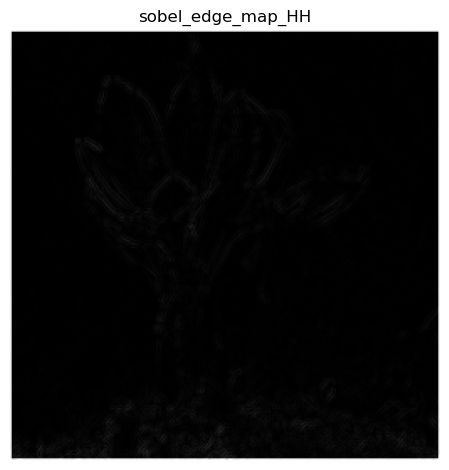

Edge map saved to: sobel_output/sobel_edge_map_HH.png


In [4]:
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as T
import os

def sobel_edge(img: torch.Tensor, normalize: bool = True, return_grads: bool = False):
    """
    Apply Sobel edge detection to a 4D tensor image (B, C, H, W).

    Args:
        img (torch.Tensor): Input tensor with shape (B, C, H, W), values in [0, 1].
        normalize (bool): If True, normalize edge magnitude to [0, 1].
        return_grads (bool): If True, also return grad_x and grad_y.

    Returns:
        edge (torch.Tensor): Sobel edge magnitude map, shape (B, 1, H, W)
        grad_x (optional): Horizontal gradient.
        grad_y (optional): Vertical gradient.
    """
    if img.shape[1] == 3:
        # Convert to grayscale using broadcasted channel weights
        img = 0.2989 * img[:, 0:1, :, :] + 0.5870 * img[:, 1:2, :, :] + 0.1140 * img[:, 2:3, :, :]

    # Define Sobel kernels
    sobel_x = torch.tensor([[[-1, 0, 1],
                             [-2, 0, 2],
                             [-1, 0, 1]]], dtype=torch.float32, device=img.device).unsqueeze(0)
    sobel_y = torch.tensor([[[-1, -2, -1],
                             [ 0,  0,  0],
                             [ 1,  2,  1]]], dtype=torch.float32, device=img.device).unsqueeze(0)

    # Apply 2D convolution
    grad_x = F.conv2d(img, sobel_x, padding=1)
    grad_y = F.conv2d(img, sobel_y, padding=1)

    # Compute edge magnitude
    edge = torch.sqrt(grad_x ** 2 + grad_y ** 2 + 1e-6)

    if normalize:
        edge = edge / (edge.max() + 1e-6)

    if return_grads:
        return edge, grad_x, grad_y
    return edge

# ------------------------------
# Example usage
# ------------------------------
if __name__ == "__main__":
    # Load image and convert to tensor
    image_path = "./output_wavelet_bands/HH_band.png" # ← Replace with your image filename
    image = Image.open(image_path).convert("RGB")
    transform = T.Compose([
        T.Resize((256, 256)),
        T.ToTensor(),
    ])
    img_tensor = transform(image).unsqueeze(0)

    # Run Sobel edge detection
    edge_map = sobel_edge(img_tensor)

    # Save the edge map figure
    save_dir = "sobel_output"
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, "sobel_edge_map_HH.png")

    # Plot and save
    plt.imshow(edge_map.squeeze().cpu().numpy(), cmap="gray")
    plt.title("sobel_edge_map_HH")
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.show()

    print(f"Edge map saved to: {save_path}")


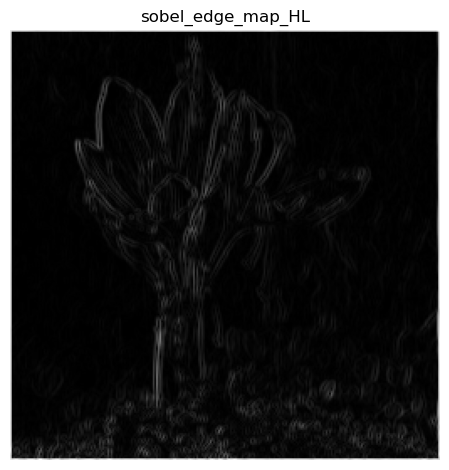

Edge map saved to: sobel_output/sobel_edge_map_HL.png


In [5]:
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as T
import os

def sobel_edge(img: torch.Tensor, normalize: bool = True, return_grads: bool = False):
    """
    Apply Sobel edge detection to a 4D tensor image (B, C, H, W).

    Args:
        img (torch.Tensor): Input tensor with shape (B, C, H, W), values in [0, 1].
        normalize (bool): If True, normalize edge magnitude to [0, 1].
        return_grads (bool): If True, also return grad_x and grad_y.

    Returns:
        edge (torch.Tensor): Sobel edge magnitude map, shape (B, 1, H, W)
        grad_x (optional): Horizontal gradient.
        grad_y (optional): Vertical gradient.
    """
    if img.shape[1] == 3:
        # Convert to grayscale using broadcasted channel weights
        img = 0.2989 * img[:, 0:1, :, :] + 0.5870 * img[:, 1:2, :, :] + 0.1140 * img[:, 2:3, :, :]

    # Define Sobel kernels
    sobel_x = torch.tensor([[[-1, 0, 1],
                             [-2, 0, 2],
                             [-1, 0, 1]]], dtype=torch.float32, device=img.device).unsqueeze(0)
    sobel_y = torch.tensor([[[-1, -2, -1],
                             [ 0,  0,  0],
                             [ 1,  2,  1]]], dtype=torch.float32, device=img.device).unsqueeze(0)

    # Apply 2D convolution
    grad_x = F.conv2d(img, sobel_x, padding=1)
    grad_y = F.conv2d(img, sobel_y, padding=1)

    # Compute edge magnitude
    edge = torch.sqrt(grad_x ** 2 + grad_y ** 2 + 1e-6)

    if normalize:
        edge = edge / (edge.max() + 1e-6)

    if return_grads:
        return edge, grad_x, grad_y
    return edge

# ------------------------------
# Example usage
# ------------------------------
if __name__ == "__main__":
    # Load image and convert to tensor
    image_path = "./output_wavelet_bands/HL_band.png" # ← Replace with your image filename
    image = Image.open(image_path).convert("RGB")
    transform = T.Compose([
        T.Resize((256, 256)),
        T.ToTensor(),
    ])
    img_tensor = transform(image).unsqueeze(0)

    # Run Sobel edge detection
    edge_map = sobel_edge(img_tensor)

    # Save the edge map figure
    save_dir = "sobel_output"
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, "sobel_edge_map_HL.png")

    # Plot and save
    plt.imshow(edge_map.squeeze().cpu().numpy(), cmap="gray")
    plt.title("sobel_edge_map_HL")
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.show()

    print(f"Edge map saved to: {save_path}")


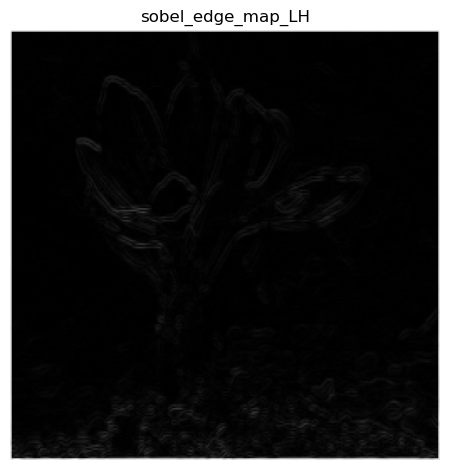

Edge map saved to: sobel_output/sobel_edge_map_LH.png


In [6]:
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as T
import os

def sobel_edge(img: torch.Tensor, normalize: bool = True, return_grads: bool = False):
    """
    Apply Sobel edge detection to a 4D tensor image (B, C, H, W).

    Args:
        img (torch.Tensor): Input tensor with shape (B, C, H, W), values in [0, 1].
        normalize (bool): If True, normalize edge magnitude to [0, 1].
        return_grads (bool): If True, also return grad_x and grad_y.

    Returns:
        edge (torch.Tensor): Sobel edge magnitude map, shape (B, 1, H, W)
        grad_x (optional): Horizontal gradient.
        grad_y (optional): Vertical gradient.
    """
    if img.shape[1] == 3:
        # Convert to grayscale using broadcasted channel weights
        img = 0.2989 * img[:, 0:1, :, :] + 0.5870 * img[:, 1:2, :, :] + 0.1140 * img[:, 2:3, :, :]

    # Define Sobel kernels
    sobel_x = torch.tensor([[[-1, 0, 1],
                             [-2, 0, 2],
                             [-1, 0, 1]]], dtype=torch.float32, device=img.device).unsqueeze(0)
    sobel_y = torch.tensor([[[-1, -2, -1],
                             [ 0,  0,  0],
                             [ 1,  2,  1]]], dtype=torch.float32, device=img.device).unsqueeze(0)

    # Apply 2D convolution
    grad_x = F.conv2d(img, sobel_x, padding=1)
    grad_y = F.conv2d(img, sobel_y, padding=1)

    # Compute edge magnitude
    edge = torch.sqrt(grad_x ** 2 + grad_y ** 2 + 1e-6)

    if normalize:
        edge = edge / (edge.max() + 1e-6)

    if return_grads:
        return edge, grad_x, grad_y
    return edge

# ------------------------------
# Example usage
# ------------------------------
if __name__ == "__main__":
    # Load image and convert to tensor
    image_path = "./output_wavelet_bands/LH_band.png" # ← Replace with your image filename
    image = Image.open(image_path).convert("RGB")
    transform = T.Compose([
        T.Resize((256, 256)),
        T.ToTensor(),
    ])
    img_tensor = transform(image).unsqueeze(0)

    # Run Sobel edge detection
    edge_map = sobel_edge(img_tensor)

    # Save the edge map figure
    save_dir = "sobel_output"
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, "sobel_edge_map_LH.png")

    # Plot and save
    plt.imshow(edge_map.squeeze().cpu().numpy(), cmap="gray")
    plt.title("sobel_edge_map_LH")
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.show()

    print(f"Edge map saved to: {save_path}")


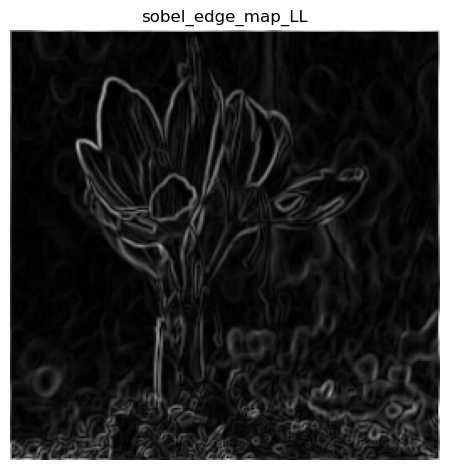

Edge map saved to: sobel_output/sobel_edge_map_LL.png


In [7]:
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as T
import os

def sobel_edge(img: torch.Tensor, normalize: bool = True, return_grads: bool = False):
    """
    Apply Sobel edge detection to a 4D tensor image (B, C, H, W).

    Args:
        img (torch.Tensor): Input tensor with shape (B, C, H, W), values in [0, 1].
        normalize (bool): If True, normalize edge magnitude to [0, 1].
        return_grads (bool): If True, also return grad_x and grad_y.

    Returns:
        edge (torch.Tensor): Sobel edge magnitude map, shape (B, 1, H, W)
        grad_x (optional): Horizontal gradient.
        grad_y (optional): Vertical gradient.
    """
    if img.shape[1] == 3:
        # Convert to grayscale using broadcasted channel weights
        img = 0.2989 * img[:, 0:1, :, :] + 0.5870 * img[:, 1:2, :, :] + 0.1140 * img[:, 2:3, :, :]

    # Define Sobel kernels
    sobel_x = torch.tensor([[[-1, 0, 1],
                             [-2, 0, 2],
                             [-1, 0, 1]]], dtype=torch.float32, device=img.device).unsqueeze(0)
    sobel_y = torch.tensor([[[-1, -2, -1],
                             [ 0,  0,  0],
                             [ 1,  2,  1]]], dtype=torch.float32, device=img.device).unsqueeze(0)

    # Apply 2D convolution
    grad_x = F.conv2d(img, sobel_x, padding=1)
    grad_y = F.conv2d(img, sobel_y, padding=1)

    # Compute edge magnitude
    edge = torch.sqrt(grad_x ** 2 + grad_y ** 2 + 1e-6)

    if normalize:
        edge = edge / (edge.max() + 1e-6)

    if return_grads:
        return edge, grad_x, grad_y
    return edge

# ------------------------------
# Example usage
# ------------------------------
if __name__ == "__main__":
    # Load image and convert to tensor
    image_path = "./output_wavelet_bands/LL_band.png" # ← Replace with your image filename
    image = Image.open(image_path).convert("RGB")
    transform = T.Compose([
        T.Resize((256, 256)),
        T.ToTensor(),
    ])
    img_tensor = transform(image).unsqueeze(0)

    # Run Sobel edge detection
    edge_map = sobel_edge(img_tensor)

    # Save the edge map figure
    save_dir = "sobel_output"
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, "sobel_edge_map_LL.png")

    # Plot and save
    plt.imshow(edge_map.squeeze().cpu().numpy(), cmap="gray")
    plt.title("sobel_edge_map_LL")
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.show()

    print(f"Edge map saved to: {save_path}")


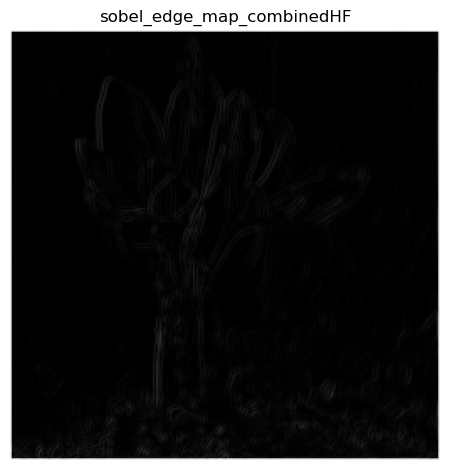

Edge map saved to: sobel_output/sobel_edge_map_combinedHF.png


In [8]:
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as T
import os

def sobel_edge(img: torch.Tensor, normalize: bool = True, return_grads: bool = False):
    """
    Apply Sobel edge detection to a 4D tensor image (B, C, H, W).

    Args:
        img (torch.Tensor): Input tensor with shape (B, C, H, W), values in [0, 1].
        normalize (bool): If True, normalize edge magnitude to [0, 1].
        return_grads (bool): If True, also return grad_x and grad_y.

    Returns:
        edge (torch.Tensor): Sobel edge magnitude map, shape (B, 1, H, W)
        grad_x (optional): Horizontal gradient.
        grad_y (optional): Vertical gradient.
    """
    if img.shape[1] == 3:
        # Convert to grayscale using broadcasted channel weights
        img = 0.2989 * img[:, 0:1, :, :] + 0.5870 * img[:, 1:2, :, :] + 0.1140 * img[:, 2:3, :, :]

    # Define Sobel kernels
    sobel_x = torch.tensor([[[-1, 0, 1],
                             [-2, 0, 2],
                             [-1, 0, 1]]], dtype=torch.float32, device=img.device).unsqueeze(0)
    sobel_y = torch.tensor([[[-1, -2, -1],
                             [ 0,  0,  0],
                             [ 1,  2,  1]]], dtype=torch.float32, device=img.device).unsqueeze(0)

    # Apply 2D convolution
    grad_x = F.conv2d(img, sobel_x, padding=1)
    grad_y = F.conv2d(img, sobel_y, padding=1)

    # Compute edge magnitude
    edge = torch.sqrt(grad_x ** 2 + grad_y ** 2 + 1e-6)

    if normalize:
        edge = edge / (edge.max() + 1e-6)

    if return_grads:
        return edge, grad_x, grad_y
    return edge

# ------------------------------
# Example usage
# ------------------------------
if __name__ == "__main__":
    # Load image and convert to tensor
    image_path = "./output_wavelet_bands/combined_HF_bands.png" # ← Replace with your image filename
    image = Image.open(image_path).convert("RGB")
    transform = T.Compose([
        T.Resize((256, 256)),
        T.ToTensor(),
    ])
    img_tensor = transform(image).unsqueeze(0)

    # Run Sobel edge detection
    edge_map = sobel_edge(img_tensor)

    # Save the edge map figure
    save_dir = "sobel_output"
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, "sobel_edge_map_combinedHF.png")

    # Plot and save
    plt.imshow(edge_map.squeeze().cpu().numpy(), cmap="gray")
    plt.title("sobel_edge_map_combinedHF")
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.show()

    print(f"Edge map saved to: {save_path}")


In [9]:
Texture-Preserving Perceptual Loss

SyntaxError: invalid syntax (1394746465.py, line 1)